In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import os

# Modelo Transformer ViT

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ViT espera 3 canales
    transforms.Resize((224,224)),                 # ViT espera 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # normalización básica
])


In [3]:
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
data_dir  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023_tinto_synthetic_images_prueba")

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

num_classes = len(dataset.classes)
print("Número de clases:", num_classes)

Número de clases: 7


## Limpieza de datos

In [4]:
# --- eliminar clase 02  ---
desc_cat = "02"
if desc_cat in dataset.class_to_idx:
    idx_c2 = dataset.class_to_idx[desc_cat]
    dataset.samples = [s for s in dataset.samples if s[1] != idx_c2]
    dataset.targets = [t for t in dataset.targets if t != idx_c2]
    print(f" Clase {desc_cat} eliminada (índice antiguo {idx_c2}).")
else:
    print(f"ℹ No existe carpeta {desc_cat}; no se filtró nada.")

# --- remapear etiquetas a 0..K-1 (crítico) ---
unique_old = sorted(set(t for _, t in dataset.samples))
old2new = {old:i for i, old in enumerate(unique_old)}
dataset.samples = [(p, old2new[t]) for (p, t) in dataset.samples]
dataset.targets = [old2new[t] for t in dataset.targets]

# reconstruir mapping de nombres de carpeta a índices nuevos
idx2class = {v:k for k,v in dataset.class_to_idx.items()}
dataset.class_to_idx = {idx2class[old]: new for old, new in old2new.items()}
dataset.classes = [c for c,_ in sorted(dataset.class_to_idx.items(), key=lambda kv: kv[1])]

num_classes = len(dataset.classes)
print("Clases activas:", dataset.classes)
print("Nuevo class_to_idx:", dataset.class_to_idx)
print("num_classes:", num_classes)

 Clase 02 eliminada (índice antiguo 1).
Clases activas: ['01', '03', '04', '06', '07', '10']
Nuevo class_to_idx: {'01': 0, '03': 1, '04': 2, '06': 3, '07': 4, '10': 5}
num_classes: 6


## Preparar entrenamiento

In [5]:
from torch.utils.data import random_split, DataLoader

n = len(dataset)
n_tr = int(0.7*n)
train_ds, test_ds = random_split(dataset, [n_tr, n-n_tr], generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=torch.cuda.is_available())
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

## Definir modelo

In [6]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vit_b_16(weights=None)  # (o weights="IMAGENET1K_V1" para fine-tuning)
model.heads = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

## Entrenamiento y validacion

In [7]:
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- entrenar SOLO la cabeza (linear probe) ---
# congela todo
for p in model.parameters():
    p.requires_grad = False

# localiza la cabeza (torchvision usa "heads", timm usa "head")
head = getattr(model, "head", None) or getattr(model, "heads", None)
if head is None:
    raise RuntimeError("No se encontró 'head'/'heads' en el modelo ViT.")
for p in head.parameters():
    p.requires_grad = True

# optimizador SOLO de la cabeza (más rápido)
opt  = torch.optim.Adam(head.parameters(), lr=2e-4)
crit = nn.CrossEntropyLoss()

use_cuda = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)
if use_cuda:
    torch.backends.cudnn.benchmark = True  # acelera convoluciones si aplica

# --- entrenamiento (pocas épocas y AMP) ---
epochs = 1  # prueba rápida; sube a 2–3 cuando quieras
t0 = time.perf_counter()
for _ in range(epochs):
    model.train()
    for x, y in train_dl:
        x, y = x.to(device, non_blocking=use_cuda), y.to(device, non_blocking=use_cuda)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_cuda):
            logits = model(x)
            loss   = crit(logits, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
t1 = time.perf_counter()
fit_s = t1 - t0
print(f"⏱ ViT – entrenamiento (linear probe, {epochs} ep): {fit_s:.2f}s")

# --- inferencia (AMP y no_grad) ---
t0 = time.perf_counter()
y_true, y_pred = [], []
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_cuda):
    for x, y in test_dl:
        x = x.to(device, non_blocking=use_cuda)
        logits = model(x)
        preds = logits.argmax(1).cpu().tolist()
        y_pred += preds
        y_true += y.tolist()
t1 = time.perf_counter()
pred_s = t1 - t0
print(f"⏱ ViT – predicción: {pred_s:.3f}s  ({pred_s/len(y_true)*1000:.2f} ms/muestra)")

C:\Users\Fran\AppData\Local\Temp\ipykernel_82784\1850584489.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)
C:\Users\Fran\AppData\Local\Temp\ipykernel_82784\1850584489.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_cuda):


⏱ ViT – entrenamiento (linear probe, 1 ep): 892.32s


C:\Users\Fran\AppData\Local\Temp\ipykernel_82784\1850584489.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_cuda):


⏱ ViT – predicción: 371.553s  (42.41 ms/muestra)


## Metricas

In [8]:
import numpy as np
# ----- 6) Métricas extras -----
# --- métricas ---
oa  = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
cm  = confusion_matrix(y_true, y_pred)
cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

print(f"OA: {oa:.3f}")
print(f"F1 macro: {f1m:.3f}")
print("Matriz de confusión:\n", cm)
print("Matriz de confusión porcentajes:\n", cm_row_percentage)
print("\nReporte por clase:\n", classification_report(y_true, y_pred, target_names=dataset.classes, digits=3))

OA: 0.521
F1 macro: 0.114
Matriz de confusión:
 [[   0 2444    0    0    0    0]
 [   0 4564    0    0    0    0]
 [   0  332    0    0    0    0]
 [   0  363    0    0    0    0]
 [   0  433    0    0    0    0]
 [   0  624    0    0    0    0]]
Matriz de confusión porcentajes:
 [[  0. 100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]]

Reporte por clase:
               precision    recall  f1-score   support

          01      0.000     0.000     0.000      2444
          03      0.521     1.000     0.685      4564
          04      0.000     0.000     0.000       332
          06      0.000     0.000     0.000       363
          07      0.000     0.000     0.000       433
          10      0.000     0.000     0.000       624

    accuracy                          0.521      8760
   macro avg      0.087     0.167     0.114      8760
weighted av

c:\Users\Fran\anaconda3\envs\tintoenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fran\anaconda3\envs\tintoenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fran\anaconda3\envs\tintoenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Matriz de confusion

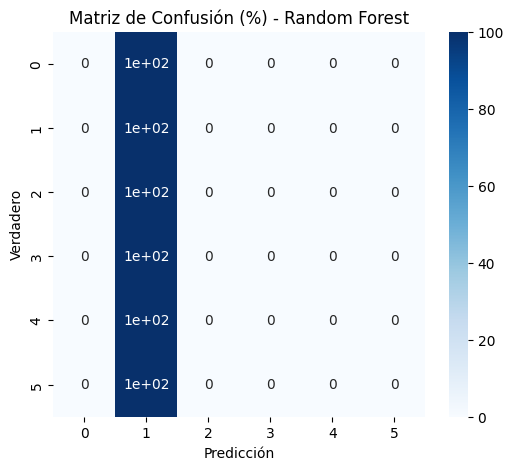

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- calcular matriz de confusión con los últimos resultados ---
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm_row_percentage, annot=True, cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (%) - Random Forest")
plt.show()

# Registrar informacion

In [ ]:
import sys
sys.path.append("..")
import importlib, utils_log
importlib.reload(utils_log)
from utils_log import log_row

carpeta_actual = ruta_carpeta_actual.split("\\")[-1]
dataset_utilizado = data_dir.split("\\")[-1]

log_row(
  script="20250901_PruebasEntrenamientoViT.ipynb",
  algoritmo="ViT_tiny_linear_probe",   # o "ViT_base_full"
  dataset=dataset_utilizado,
  clases_removidas=["02"],
  seed=42,
  n_train=len(train_ds), n_test=len(test_ds),
  n_features=None, num_classes=num_classes,
  fit_seconds=fit_s, pred_seconds=pred_s,
  ms_per_sample=(pred_s/len(y_true))*1000,
  OA=oa, F1_macro=f1m,
  carpeta=carpeta_actual
)